In [1]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)

from util import *
from functions_to_sample import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from tqdm import tqdm
from tabulate import tabulate
import scipy.ndimage

from IPython.display import display, clear_output
import time

import plotly.graph_objects as go
import plotly.express as px

import math

import GPy
import safeopt
import pickle

# Seeds
np.random.seed(42)
random.seed(42)

In [2]:
comfort_dfs_names = [f for f in os.listdir('comfort_80_files') if f.startswith('comf')]
comfort_dfs_names = sorted(comfort_dfs_names, key=lambda x: int(x.split('_')[2]))

In [3]:
w_elec_std = 128.00731831706653
T_dis_std = 353.5533905932738

In [4]:
# MULTI AGENT
dmabo_inputs = np.array([20.26420231, 21.40019706, 21.86297906, 22., 21.12387095, 21.71548845,
                 20.04134941, 21.32234442, 21.94098025, 20.22901101, 21.00381179, 21.85439573,
                 21.5763485, 21.61204715, 21.92018737, 21.29056703, 22., 22.,
                 20.10307897, 20.60020666, 21.25594776, 20.84688737, 19.94108796, 16.,
                 20.04910924, 21.32248939, 21.88546604, 22., 22., 22.]).reshape(-1, 3)

dmabo_inputs = np.array([
                        20.31396854, 20.32818862, 21.99999957, 22., 22., 21.98197417,
                        20.11383863, 20.03735596, 22., 20.19658724, 21.48268801, 22.,
                        21.6096383, 21.64095884, 21.94617378, 21.26039808, 21.55531473, 21.99142934,
                        20.0468777, 20.8675687, 22., 19.43019876, 21.25164401, 21.8863798,
                        19.98381335, 20.98831662, 22., 21.98748042, 22., 22.
                    ]).reshape((-1, 3), order='C')


# SINGLE AGENT:
sigopt_inputs = np.array([[20.81171805, 21.06435547, 21.97580792],
       [21.3204375 , 21.74166038, 22.        ],
       [21.31434691, 21.73717508, 21.99442961],
       [21.31077499, 21.7334268 , 21.98960614],
       [21.32043749, 21.74166037, 22.        ],
       [21.32043746, 21.74166037, 22.        ],
       [21.31439439, 21.7372249 , 21.99449373],
       [20.15555144, 20.50870409, 20.51536297],
       [20.91249124, 21.22845482, 22.        ],
       [21.32043748, 21.74166037, 22.        ]])

sigopt_inputs = np.array([[21.09458759, 21.54005619, 21.74505225],
       [21.26886534, 21.73054195, 22.        ],
       [20.71204229, 21.03993315, 21.15286574],
       [20.72674835, 20.9193062 , 21.67562734],
       [21.26886529, 21.73054189, 22.        ],
       [21.26886529, 21.73054189, 22.        ],
       [20.83110693, 21.13438471, 21.62829691],
       [20.27155424, 20.57502122, 20.68343532],
       [21.01554962, 21.49939405, 21.70338862],
       [21.26886529, 21.73054189, 22.        ]])

In [5]:
w_elec_total = np.zeros(3)
T_dis_total = 0
T_dis_list_20 = []
w_elec_list_20 = []
T_dis_list_21 = []
w_elec_list_21 = []
T_dis_list_22 = []
w_elec_list_22 = []
T_dis_list_sigopt = []
w_elec_list_sigopt = []
T_dis_list_dmabo = []
w_elec_list_dmabo = []

for i in range(10):
    temp, welec_hour = simulation_output(np.array([20, 20, 20]))
    w_elec = calculate_welec(welec_hour)

    comf_df = pd.read_csv(f'comfort_80_files/{comfort_dfs_names[i]}')
    comf_df['time'] = pd.DatetimeIndex(pd.to_datetime(comf_df['time']))
    comf_df = comf_df.set_index('time')

    T_dis = calculate_discomfort(comf_df, temp)

    T_dis_list_20.append(T_dis)
    w_elec_list_20.append(w_elec)

for i in range(10):
    temp, welec_hour = simulation_output(np.array([21, 21, 21]))
    w_elec = calculate_welec(welec_hour)

    comf_df = pd.read_csv(f'comfort_80_files/{comfort_dfs_names[i]}')
    comf_df['time'] = pd.DatetimeIndex(pd.to_datetime(comf_df['time']))
    comf_df = comf_df.set_index('time')

    T_dis = calculate_discomfort(comf_df, temp)

    T_dis_list_21.append(T_dis)
    w_elec_list_21.append(w_elec)

for i in range(10):
    temp, welec_hour = simulation_output(np.array([22, 22, 22]))
    w_elec = calculate_welec(welec_hour)

    comf_df = pd.read_csv(f'comfort_80_files/{comfort_dfs_names[i]}')
    comf_df['time'] = pd.DatetimeIndex(pd.to_datetime(comf_df['time']))
    comf_df = comf_df.set_index('time')

    T_dis = calculate_discomfort(comf_df, temp)

    T_dis_list_22.append(T_dis)
    w_elec_list_22.append(w_elec)

for i in range(10):
    temp, welec_hour = simulation_output(sigopt_inputs[i])
    w_elec = calculate_welec(welec_hour)

    comf_df = pd.read_csv(f'comfort_80_files/{comfort_dfs_names[i]}')
    comf_df['time'] = pd.DatetimeIndex(pd.to_datetime(comf_df['time']))
    comf_df = comf_df.set_index('time')

    T_dis = calculate_discomfort(comf_df, temp)

    T_dis_list_sigopt.append(T_dis)
    w_elec_list_sigopt.append(w_elec)

    w_elec_total += w_elec #/ w_elec_std
    T_dis_total += T_dis #/ T_dis_std

for i in range(10):
    temp, welec_hour = simulation_output(dmabo_inputs[i])
    w_elec = calculate_welec(welec_hour)

    comf_df = pd.read_csv(f'comfort_80_files/{comfort_dfs_names[i]}')
    comf_df['time'] = pd.DatetimeIndex(pd.to_datetime(comf_df['time']))
    comf_df = comf_df.set_index('time')

    T_dis = calculate_discomfort(comf_df, temp)

    T_dis_list_dmabo.append(T_dis)
    w_elec_list_dmabo.append(w_elec)

    w_elec_total += w_elec #/ w_elec_std
    T_dis_total += T_dis #/ T_dis_std

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


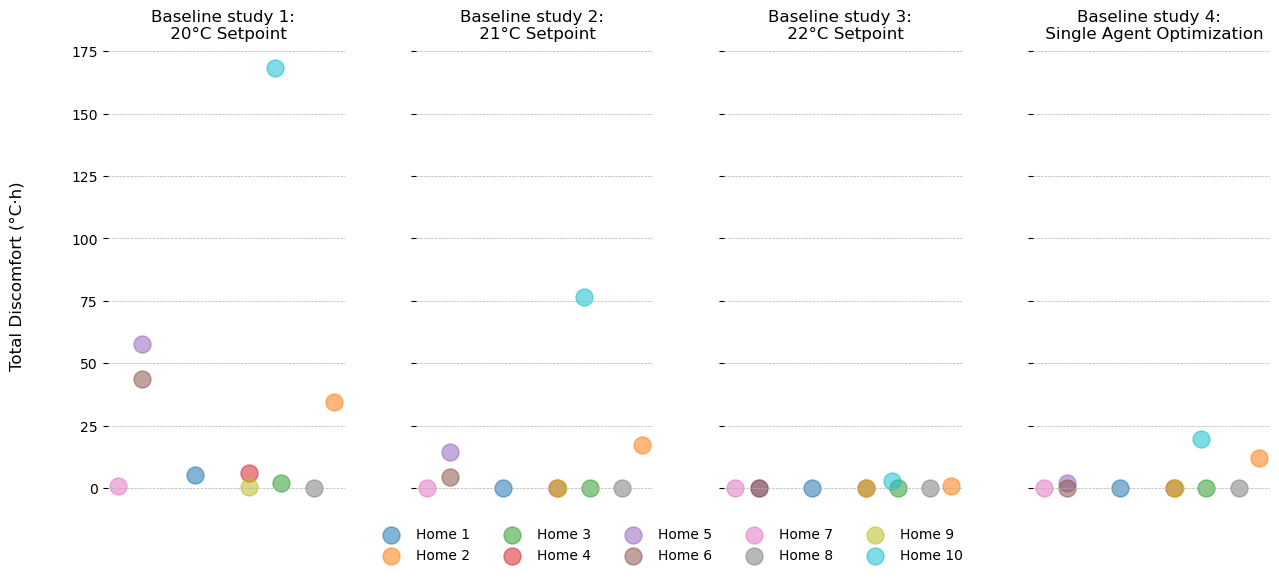

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Data
values1 = T_dis_list_20
values2 = T_dis_list_21
values3 = T_dis_list_22
values4 = T_dis_list_sigopt

# Divide by 4 (currently in 15 minute intervals, we want hourly)
values1 = [x / 4 for x in values1]
values2 = [x / 4 for x in values2]
values3 = [x / 4 for x in values3]
values4 = [x / 4 for x in values4]

# Colormap
colors = plt.cm.get_cmap('tab10', 10)

# Random x positions
random_x_positions = np.random.rand(len(values1)) * 2 + 1

# Create figure and subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 6), sharey=True)

# Tight layout for subplots
fig.subplots_adjust(wspace=0.3)

# Scatter plots with unique colors
handles = []
for i in range(len(values1)):
    color = colors(i)
    handle1 = ax1.scatter(random_x_positions[i], values1[i], s=150, c=[color], alpha=0.55, label=f'Home {i+1}')
    ax2.scatter(random_x_positions[i], values2[i], s=150, c=[color], alpha=0.55)
    ax3.scatter(random_x_positions[i], values3[i], s=150, c=[color], alpha=0.55)
    ax4.scatter(random_x_positions[i], values4[i], s=150, c=[color], alpha=0.55)
    handles.append(handle1)

# Titles and labels
ax1.set_title('Baseline study 1: \n 20°C Setpoint')
ax2.set_title('Baseline study 2: \n 21°C Setpoint')
ax3.set_title('Baseline study 3: \n 22°C Setpoint')
ax4.set_title('Baseline study 4: \n Single Agent Optimization')
fig.text(0.06, 0.5, 'Total Discomfort (°C⋅h)', va='center', rotation='vertical', fontsize=12)

# Grids
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax4.grid(True, which='both', linestyle='--', linewidth=0.5)

# Hide x-ticks and box
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)

# Legend below the plots
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5, frameon=False)

plt.savefig('comfort/discomfort_baseline.eps', format='eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


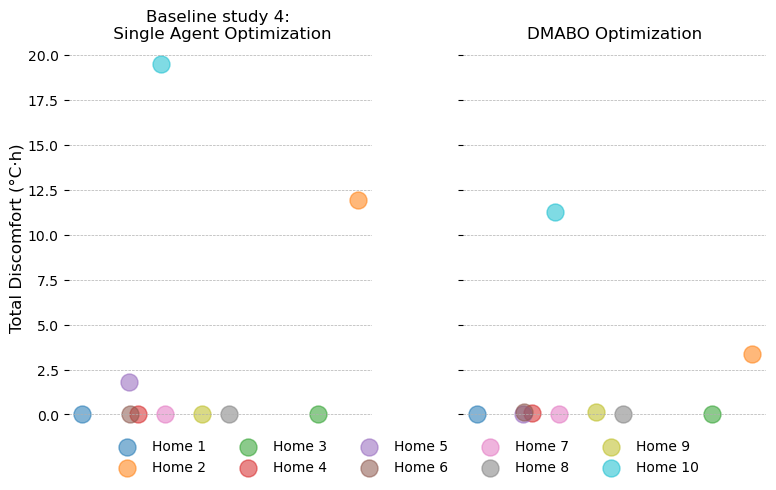

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Data
values5 = T_dis_list_dmabo

# Divide by 4 (currently in 15 minute intervals, we want hourly)
values15 = [x / 4 for x in values5]

# Colormap
colors = plt.cm.get_cmap('tab10', 10)

# Random x positions
random_x_positions = np.random.rand(len(values1)) * 2 + 1

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), sharey=True)

# Tight layout for subplots
fig.subplots_adjust(wspace=0.3)

# Scatter plots with unique colors
handles = []
for i in range(len(values1)):
    color = colors(i)
    handle1 = ax1.scatter(random_x_positions[i], values4[i], s=150, c=[color], alpha=0.55, label=f'Home {i+1}')
    ax2.scatter(random_x_positions[i], values5[i], s=150, c=[color], alpha=0.55)
    handles.append(handle1)

# Titles and labels
ax1.set_title('Baseline study 4: \n Single Agent Optimization')
ax2.set_title('DMABO Optimization')
fig.text(0.06, 0.5, 'Total Discomfort (°C⋅h)', va='center', rotation='vertical', fontsize=12)

# Grids
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Hide x-ticks and box
ax1.set_xticks([])
ax2.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Legend below the plots
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5, frameon=False)

plt.savefig('comfort/discomfort_dmabo.eps', format='eps', bbox_inches='tight')
plt.show()

In [8]:
sum(values3) # 22

3.5198977498371264

In [9]:
sum(values4) # sigopt

33.248599206751486

In [10]:
sum(values5) # DMABO

15.10718327368053

# 1. Schedules of Each Agent

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


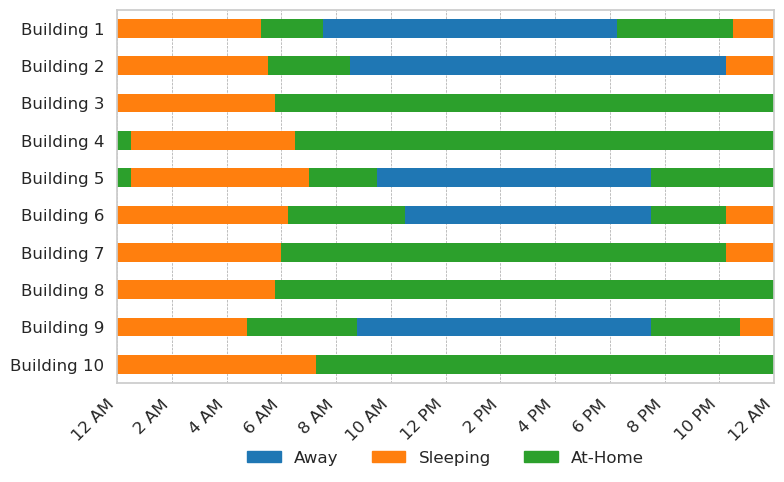

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Set a clean and professional style
sns.set(style="whitegrid")

# Define a colorblind-friendly and more solid palette
color_palette = sns.color_palette("tab10", 3)  # "tab10" offers more vibrant colors
color_map = {0: color_palette[0], 1: color_palette[1], 2: color_palette[2]}

# Assuming 'comfort_dfs_names' is defined elsewhere
schedules = []
for i in range(10):
    comf_df = pd.read_csv(f'comfort_80_files/{comfort_dfs_names[i]}')
    comf_df['time'] = pd.to_datetime(comf_df['time'])
    comf_df = comf_df.set_index('time')
    
    # Ensure that the date comparison is correct
    target_date = comf_df.index[-20].date()
    schedule_values = comf_df[comf_df.index.date == target_date]['comfort_status'].values
    schedule_values = np.append(schedule_values, [schedule_values[-1], schedule_values[-1]])
    schedules.append(schedule_values)

time_intervals = np.arange(96)

plt.figure(figsize=(8, 5))  # Slightly wider for better readability

# Plot settings
ax = plt.gca()
ax.set_xlim(0, 96)
ax.set_ylim(0, 10)
ax.grid(False)

# Adjusted settings for the bars
bar_height = 0.5  # Increased bar height for less separation
# No need for bar_spacing as we're controlling via bar_height and y positions

# For each person's schedule, create a continuous bar with changing colors
for i, schedule in enumerate(schedules):
    start = 0
    current_state = schedule[0]
    
    for j in range(1, 96):
        if schedule[j] != current_state:
            rect = Rectangle(
                (start, i + (0.5 - bar_height / 2)),
                j - start,
                bar_height,
                facecolor=color_map[current_state],
                edgecolor='none'
            )
            ax.add_patch(rect)
            start = j
            current_state = schedule[j]
    # Add the last segment
    rect = Rectangle(
        (start, i + (0.5 - bar_height / 2)),
        96 - start,
        bar_height,
        facecolor=color_map[current_state],
        edgecolor='none'
    )
    ax.add_patch(rect)

# Customizing the plot
ax.set_yticks(np.arange(0.5, 10.5, 1))
ax.set_yticklabels([f"Building {x + 1}" for x in range(10)], fontsize=12)
ax.invert_yaxis()  # Keep Building 1 at the top

# Formatting x-ticks to show hours in AM/PM format, every two hours
hour_ticks = [x * 4 for x in range(0, 25, 2)]  # 4 intervals per hour
hour_labels = [f"{(x % 12 if x % 12 != 0 else 12)} {'AM' if x < 12 else 'PM'}" for x in range(0, 24, 2)] + ["12 AM"]
ax.set_xticks(hour_ticks)
ax.set_xticklabels(hour_labels, rotation=45, ha='right', fontsize=12)

# Adding custom grid lines for x-axis
ax.xaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Adding a simplified legend
labels = ['Away', 'Sleeping', 'At-Home']  # Simplified labels
handles = [plt.Rectangle((0,0),1,1, color=color_map[i]) for i in color_map]
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.14),
          fancybox=True, shadow=False, ncol=3, frameon=False, fontsize=12)

# Adjust layout to make room for the legend
plt.tight_layout()

# Save the figure in a high-resolution format suitable for journals
plt.savefig('comfort/scheduales_10_agents.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


In [12]:
temp_df = pd.DataFrame(index = ['min', 'max', 'ideal'])
for i in range(10):
    comf_df = pd.read_csv(f'comfort_80_files/{comfort_dfs_names[i]}')
    comf_df['time'] = pd.DatetimeIndex(pd.to_datetime(comf_df['time']))
    comf_df = comf_df.set_index('time')
    # comf_df.dropna(inplace=True)
    comf_df['ideal_temp'] = (comf_df['comfort_temp_80_min'] + comf_df['comfort_temp_80_max'])/2
    comf_df.dropna(inplace=True)
    summary_df = comf_df[['comfort_temp_80_min', 'comfort_temp_80_max', 'ideal_temp']].agg('mean')
    summary_df.index = ['min', 'max', 'ideal']
    temp_df[f'House {i+1}'] = summary_df
temp_df = temp_df.T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


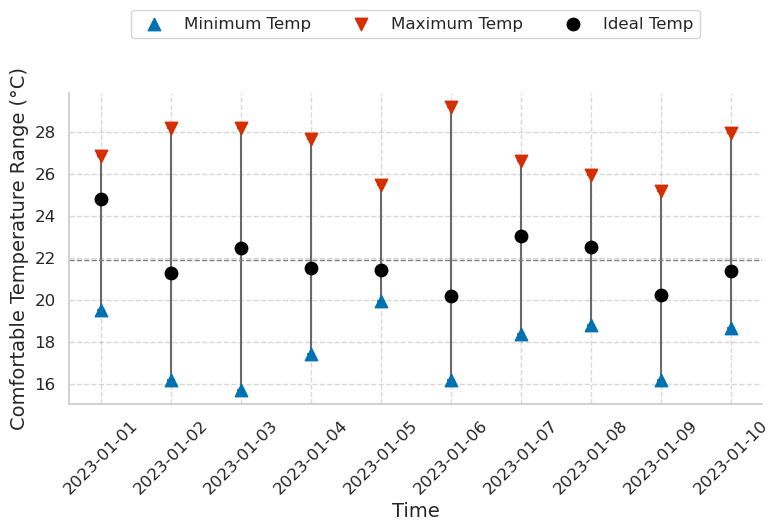

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# Example DataFrame (Replace this with your actual temp_df)
# Assuming temp_df has columns: 'ideal', 'min', 'max'
# and the index represents time or another categorical variable
# For demonstration, here's a sample temp_df
# Remove or replace this with your actual data

# Create plot with larger figure size for better resolution
fig, ax = plt.subplots(figsize=(8, 6))

# Error bars without label to exclude from legend
ax.errorbar(
    x=temp_df.index,
    y=temp_df['ideal'],
    yerr=[temp_df['ideal'] - temp_df['min'], temp_df['max'] - temp_df['ideal']],
    fmt='o',
    color='black',
    ecolor='dimgray',
    elinewidth=1.5,
    capsize=3,  # Added capsize for better visibility
    markeredgewidth=1.5,
    markersize=6,
    zorder=1
)

# Markers for min and max temperatures with higher zorder and labels
ax.scatter(
    temp_df.index,
    temp_df['min'],
    color='#0072B2',
    marker='^',
    label='Minimum Temp',
    s=80,  # Increased size for visibility
    zorder=3
)
ax.scatter(
    temp_df.index,
    temp_df['max'],
    color='#D52E00',
    marker='v',
    label='Maximum Temp',
    s=80,
    zorder=3
)
ax.scatter(
    temp_df.index,
    temp_df['ideal'],
    color='#000000',
    marker='o',
    label='Ideal Temp',
    s=80,
    zorder=3
)

# Horizontal line for average ideal temperature without label to exclude from legend
avg_ideal = temp_df['ideal'].mean()
ax.axhline(avg_ideal, color='grey', zorder=2, linewidth=1, linestyle='--')

# Set labels with increased font size for readability
ax.set_ylabel('Comfortable Temperature Range (°C)', fontsize=14)
ax.set_xlabel('Time', fontsize=14)  # Assuming x-axis represents time

# Improve x-axis ticks
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Refine grid
ax.grid(True, linestyle='--', which='major', color='grey', alpha=0.3)

# Enhance spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Place legend above the plot to avoid overlapping with data
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15), shadow=False, ncol=3, fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure in high resolution
plt.savefig('comfort/comfort_temp.eps', format='eps', bbox_inches='tight')

# Display the plot
plt.show()


 /tmp/ipykernel_2170/1568406717.py:102: UserWarning:The figure layout has changed to tight
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


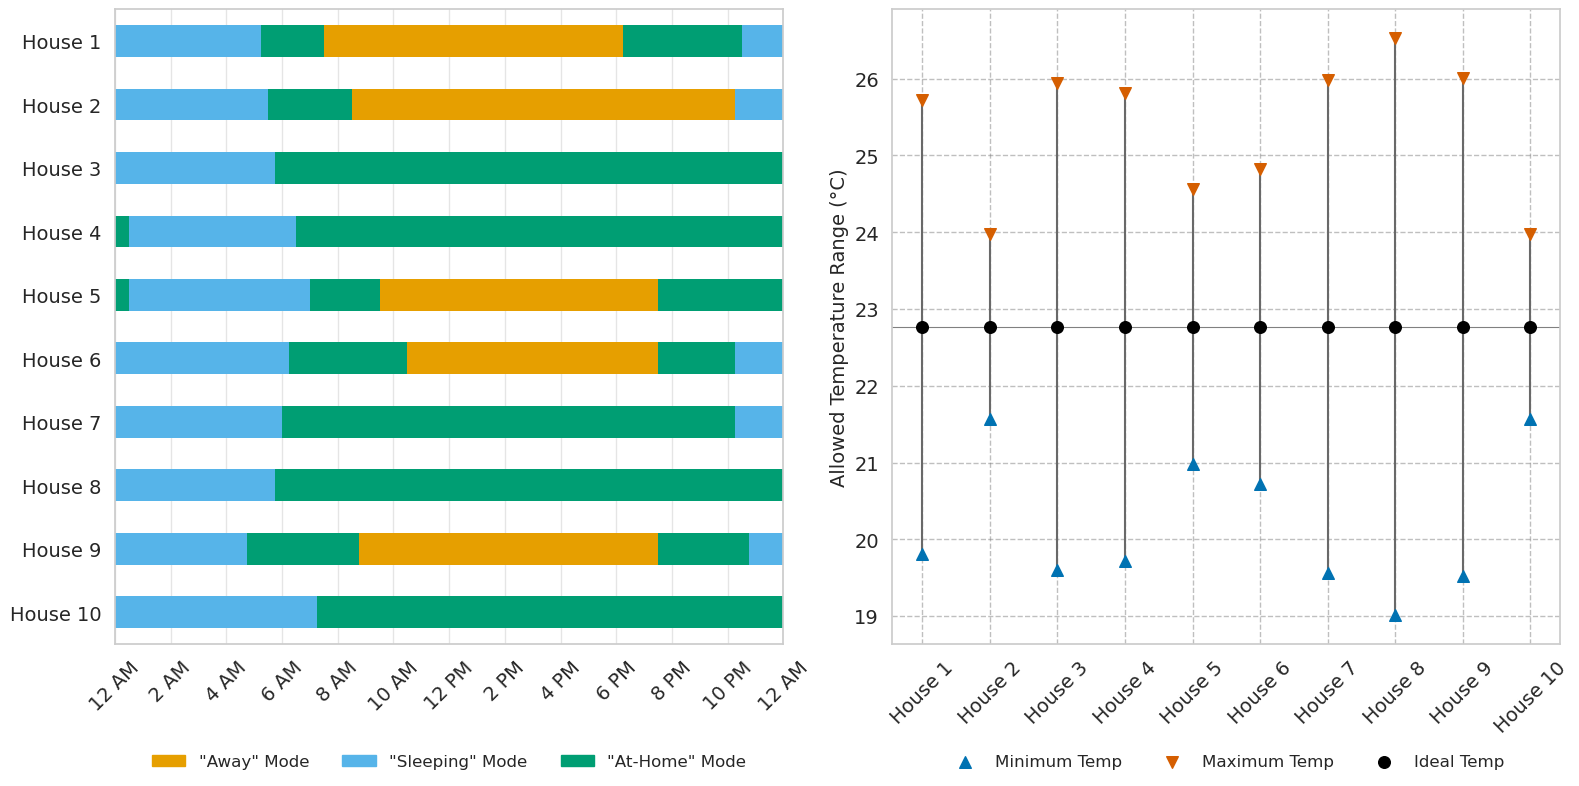

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

# Assuming 'schedules' and 'temp_df' are predefined.
# Example placeholders (remove these when using actual data):
# schedules = [np.random.randint(0, 3, size=96) for _ in range(10)]
# dates = pd.date_range(start='2023-01-01', periods=30, freq='D')
# temp_df = pd.DataFrame({
#     'min': np.random.uniform(18, 20, size=30),
#     'ideal': np.random.uniform(21, 23, size=30),
#     'max': np.random.uniform(24, 26, size=30)
# }, index=dates)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

font_size = 14  # Base font size

# First plot - Occupancy Schedules

# Plot settings
ax1.set_xlim(0, 96)
ax1.set_ylim(0, 10)
color_map = {0: '#E69F00', 1: '#56B4E9', 2: '#009E73'}

# Adjusted settings for the bars
bar_height = 0.5  # Maintaining bar height at 0.5

# For each house's schedule, create a continuous bar with changing colors
for i, schedule in enumerate(schedules):
    start = 0
    current_state = schedule[0]
    
    for j in range(1, 96):
        if schedule[j] != current_state:
            rect = Rectangle((start, i + 0.25), j - start, bar_height,
                             facecolor=color_map[current_state], edgecolor='none')
            ax1.add_patch(rect)
            start = j
            current_state = schedule[j]
    # Add the last segment
    rect = Rectangle((start, i + 0.25), 96 - start, bar_height,
                     facecolor=color_map[current_state], edgecolor='none')
    ax1.add_patch(rect)

# Customizing the plot
ax1.set_yticks([x + 0.5 for x in range(10)])
ax1.set_yticklabels([f"House {x + 1}" for x in range(10)], fontsize=font_size)
# ax1.set_xlabel("Time of Day", fontsize=font_size)
ax1.tick_params(axis='x', labelsize=font_size)
ax1.invert_yaxis()  # Invert y-axis to keep House 1 at the top

# Formatting x-ticks to show hours in AM/PM format
hour_ticks = [x * 4 for x in range(0, 25, 2)]  # 4 intervals per hour, stepping by 2 hours
hour_labels = [f"{(x % 12 or 12)} {'AM' if x < 12 else 'PM'}" for x in range(0, 24, 2)] + ["12 AM"]
ax1.set_xticks(hour_ticks)
ax1.set_xticklabels(hour_labels, rotation=45, fontsize=font_size)

# Adding grid
ax1.grid(True, which='major', axis='x', alpha=0.5)

# Adding a legend below the subplot
labels = ['"Away" Mode', '"Sleeping" Mode', '"At-Home" Mode']
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[i]) for i in color_map]
ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=3, fontsize=font_size - 2, frameon=False)

# ax1.set_title('Occupancy Schedules', fontsize=font_size + 2)

# Second plot - Temperature Settings Over Time

# Error bars with lower z-order
ax2.errorbar(x=temp_df.index, y=temp_df['ideal'],
             yerr=[temp_df['ideal'] - temp_df['min'], temp_df['max'] - temp_df['ideal']],
             fmt='o', color='black', ecolor='dimgray', elinewidth=1.5,
             capsize=0, markeredgewidth=2, zorder=1)

# Markers for min, ideal, and max temperatures with higher z-order
ax2.scatter(temp_df.index, temp_df['min'], color='#0072B2', marker='^',
            label='Minimum Temp', s=70, zorder=3)
ax2.scatter(temp_df.index, temp_df['max'], color='#D55E00', marker='v',
            label='Maximum Temp', s=70, zorder=3)
ax2.scatter(temp_df.index, temp_df['ideal'], color='#000000', marker='o',
            label='Ideal Temp', s=70, zorder=3)
ax2.axhline(temp_df['ideal'].mean(), color='grey', zorder=2, linewidth=0.8)

ax2.set_ylabel('Allowed Temperature Range (°C)', fontsize=font_size)
# ax2.set_xlabel('Date', fontsize=font_size)
ax2.tick_params(axis='x', rotation=45, labelsize=font_size)
ax2.tick_params(axis='y', labelsize=font_size)
ax2.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Place legend below the subplot
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=3, fontsize=font_size - 2, frameon=False)

# ax2.set_title('Temperature Settings Over Time', fontsize=font_size + 2)

# Adjust layout and display the plot
plt.tight_layout()

# Save the figure (ensure that legends fit within the saved figure)
plt.savefig('combined_figure.eps', format='eps', bbox_inches='tight')

plt.show()
